In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [2]:
import unnet
from unnet.samplers import *
from unnet.pipeline import *
from unnet.generators import *
from unnet.visualize import *
from unnet.centralities import *

In [3]:
n=10000
m=1
repetitions=100
minority_size=0.1
show_std=True
mode="unsafe"
homophilies = [0.1, 0.25, 0.5, 0.75, 0.9]
generator = ParametersZip(HomophilyGenerator(multi_edges="rejection"), {'n':n,
                                                 'm':m,
                                                 'minority_fraction' : minority_size,
                                                 'homophily' : homophilies})
print(show_std)

True


In [4]:
all_measures = ["degree"]#, "katz", "pagerank"]

In [5]:
tmp= []
if "degree" in all_measures:
    tmp.append(DegreeByClass(["distr","distr_cumsum", "top_places"], minlength=m*n))
if "katz" in all_measures:
    tmp.append(KatzByClass(["distr_cumsum", "top_places"], minlength=m*n))
if "pagerank" in all_measures:
    tmp.append(PagerankByClass(["distr_cumsum", "top_places"], minlength=m*n))
    

measures=JoinMeasures([*tmp,
    MinorityFraction(),
   EdgeCountByClass(['raw'])
#    BetweennessByClass(["distr_cumsum"]),
#    EigenvectorByClass(["distr_cumsum"], max_iter=1000, epsilon=1e-5),
])

In [6]:
sampling_rates=[0.1, 0.3, 0.5, 0.7, 0.9]
sampler1 = ParametersZip(EdgeSampler(), {'desired_fraction' : sampling_rates})
result1=GraphPipeline(generator, measures, sampler=sampler1).execute(repetitions=repetitions)

In [7]:
retain_fac = [0.1,0.3,0.5,0.7,0.9,1]
def plot_result(result, show_std=False, groupby=['retain_factor'], invert=False):
    for measure in all_measures:
        print("<<<<<<<<", measure)
        if not invert:
            for value in np.unique(result[groupby[0]]):
                result_tmp=result[result[groupby[0]]==value]
                fig=plot_top_places(result_tmp, show_std=show_std, measure=measure, groupby=['homophily'])

                fig.suptitle(f"{measure}, retain={value}")
                display(fig)
        else:
            for h in np.unique(result.homophily):
                result_tmp=result[result.homophily==h]
                fig=plot_top_places(result_tmp, show_std=show_std, measure=measure, groupby=groupby)
                
                fig.suptitle(f"{measure}, h={h}")
                display(fig)
        plt.show()

In [8]:
def full_extent(ax, pad=0.0):
    from matplotlib.transforms import Bbox
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.xaxis.label, ax.yaxis.label]
    #items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

In [9]:
def plot_across_noise_strength(results, h, k, ax):
    
    for name, (result, key) in results.items():
        result=result[result['homophily']==h]
        #print(result)
        m_place=[]
        s_place=[]

        if key=="no sampling":
            places = tmp['degree_min_places'].apply(lambda v: v[k]/k)
            for _ in range(len(x)):
                m_place.append(np.mean(places))
                s_place.append(np.std(places))
        else:
            x=[]
            for value in np.unique(result[key]):
                if key=='alpha':
                    x.append(value)#alpha_map[value])
                else:
                    x.append(value)
                tmp = result[result[key]==value]
                places = tmp['degree_min_places'].apply(lambda v: v[k]/k)
                #print(places,np.std(places))
                m_place.append(np.mean(places))
                s_place.append(np.std(places))
        #print(m_place, x)
        ax.errorbar(x, m_place, yerr=s_place, label=name)
    #plt.legend()
    
    
    ax.plot(x, np.full(len(x), result['minority_fraction'].iloc[0]), color="k", linestyle='dashed')
    
    #plt.title(f"h={h}")
    ax.set_ylim([-0.05,1.05])
    #ax=plt.gca()
    #ax.set_aspect('equal')
            
        
        
            
        
        
        
        
    

In [10]:
def plot_num_edges_outer(results, h, ax, relative=True):
    
    for name, (result, key) in results.items():
        result=result[result['homophily']==h]
        #print(result)
        m_place=[]
        s_place=[]
        x=[]
        for value in np.unique(result[key]):
            if key=='alpha':
                x.append(value)#alpha_map[value])
            else:
                x.append(value)
            tmp = result[result[key]==value]
            edges = tmp['edge_raw'].apply(lambda x: x.sum())
            #print(edges)
            #print(places,np.std(places))
            
            m_place.append(np.mean(edges))
            s_place.append(np.std(edges))
        #print(m_place, x)
        if relative:
            m_place=np.array(m_place)/(m*(n-1))
            s_place=np.array(s_place)/(m*(n-1))
        #print(s_place)
        ax.errorbar(x, m_place, yerr=s_place, label=name)
    #plt.legend()
    
    #plt.title(f"h={h}")
    ax.set_ylim([-0.05,1.05])
    #ax=plt.gca()
    #ax.set_aspect('equal')

In [11]:
def to_alpha(alpha, values):
    return values ** alpha
def inv_to_alpha(alpha, values):
    return (1-values) ** alpha

def inv_log_agg_function(cent1, cent2):
    """aggregates two centrality measures using logarithms and min_max_scaling
    
    """
    return 1-log_agg_function(cent1, cent2)

def inv_log_agg_function_alpha(alpha, cent1, cent2):
    """ Allows additional scaling of log_agg_function with a parameter alpha
    to roughly get retain factors for BA use
    retain factor 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,  0.7, 0.8, 0.9
    alpha         1.7, 1.0, 0.7, 0.5, 0.4, 0.26, 0.2, 0.1, 0.015 """
    return inv_log_agg_function(cent1, cent2) ** alpha

In [12]:
# Inter
matrices = [np.array([[0.9,v],[v, 0.9]]) for v in [0.1,0.3,0.5,0.7,0.9,]]
sampler_m1 = ParametersZip(BiasedEdgeSampler(), {'retain_matrix' : matrices})
# Intra
matrices = [np.array([[v,0.9],[0.9, v]]) for v in [0.1,0.3,0.5,0.7,0.9]]
sampler_m2 = ParametersZip(BiasedEdgeSampler(), {'retain_matrix' : matrices})
# Majority
matrices = [np.array([[v,v],[v, 0.9]]) for v in [0.1,0.3,0.5,0.7,0.9]]
sampler_m3 = ParametersZip(BiasedEdgeSampler(), {'retain_matrix' : matrices})
# Minority
matrices = [np.array([[0.9,v],[v, v]]) for v in [0.1,0.3,0.5,0.7,0.9]]
sampler_m4 = ParametersZip(BiasedEdgeSampler(), {'retain_matrix' : matrices})
# Uniform
sampling_rates=[0.1, 0.3, 0.5, 0.7, 0.9]
sampler_uniform = ParametersZip(EdgeSampler(), {'desired_fraction' : sampling_rates})


alphas = [1.7, 1.0, 0.7, 0.5, 0.4, 0.26, 0.2, 0.1, 0.015]
# Jaccard
samp_jaccard = AdditionalParamWrapper(SimilarityEdgeSampler(), partial(change_function_params, to_alpha), "alpha")
sampler_jaccard = ParametersZip(samp_jaccard, {'sim_type':'jaccard', 'alpha' : alphas})

# inv Jaccard
inv_jaccard = AdditionalParamWrapper(SimilarityEdgeSampler(), partial(change_function_params, inv_to_alpha), "alpha")
sampler_inv_jaccard = ParametersZip(inv_jaccard, {'sim_type':'jaccard', 'alpha' : alphas})

# Structure
from functools import partial
struct_sampler = ParametersZip(StructureEdgeSampler(log_agg_function_alpha), {
    'centrality':CentralityCache(DegreeByClass(["distr_cumsum"])),
    'alpha' : alphas })

# inv Structure
from functools import partial
inv_struct_sampler = ParametersZip(StructureEdgeSampler(inv_log_agg_function_alpha), {
    'centrality':CentralityCache(DegreeByClass(["distr_cumsum"])),
    'alpha' : alphas })

l=[
    (sampler_m1, 'inter'),
    (sampler_m2, 'intra'),
    (sampler_m3, 'majority'),
    (sampler_m4, 'minority'),
    (sampler_uniform,'uniform'),
    (IdentitySampler(), 'no sampling'),
    (sampler_jaccard, 'jaccard'),
    (sampler_inv_jaccard, 'inv jaccard'),
    (struct_sampler, 'structure'),
    (inv_struct_sampler, 'inv structure')
]

all_samplers = ChainSamplers([x[0] for x in l], names = [x[1] for x in l])
result_all = GraphPipeline(generator, measures, sampler=all_samplers).execute(repetitions=10)

In [13]:
result_all.columns

Index(['n', 'm', 'minority_fraction', 'homophily', 'retain_matrix',
       'sampler_name', 'desired_fraction', 'sim_type', 'alpha', 'centrality',
       'degree_distr_maj', 'degree_distr_min', 'degree_distr_cumsum_maj',
       'degree_distr_cumsum_maj_x', 'degree_distr_cumsum_min',
       'degree_distr_cumsum_min_x', 'degree_min_places', 'degree_maj_places',
       'minority_measured', 'edge_raw', 'run'],
      dtype='object')

In [14]:
result_all['rate']=result_all.retain_matrix.apply(np.min)

In [15]:
filetype='png'

<ipython-input-16-9f70c2ec9045>:5: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
/home/felix/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


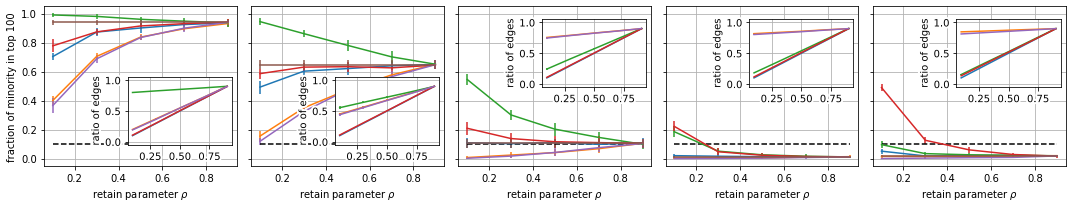

In [16]:

from matplotlib.transforms import IdentityTransform, TransformedBbox
def by_name(result_all, name):
    return result_all[result_all.sampler_name == name]
hs = [0.1,0.25, 0.5,0.75,0.9]
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
fig, axs = plt.subplots(1, len(hs),figsize=(15, 3), sharey=True)
fig.set_tight_layout(True)
for ax, h in zip(axs, hs):
    
    #ax1 = plt.subplots(1,len(hs),i+1, sharey=True)
    plot_across_noise_strength({
        'random' : (by_name(result_all,'uniform'), 'desired_fraction'),
#        'structure' : (result2,'alpha'),
        'inter' : (by_name(result_all,'inter'),'rate'),
        'intra' : (by_name(result_all,'intra'),'rate'),
        'majority' : (by_name(result_all,'majority'),'rate'),
        'minority' : (by_name(result_all,'minority'),'rate'),
        'no noise' : (by_name(result_all,'minority'),'no sampling'),
#        'jaccard' : (result5, 'alpha')
    },
                               h=h,
                               k=100,
    ax=ax)
    ax.set_xlabel(r"retain parameter $\rho$")
    #ax.set_xlim([0.01,0.99])
    ax.grid(True)
axs[0].set_ylabel(f"fraction of minority in top {100}")
#axs[0].legend(fontsize=16)
#plt.show()
import matplotlib.patches as patches
axs2 = []
locs = [4,4,1,1,1]
for ax,loc in zip(axs, locs):
    #ax.add_patch(patches.Rectangle((0.2,0.1),0.6,0.5, fc="red"))
    ax2 =  inset_axes(ax, width="60%", height="50%", loc=loc, bbox_to_anchor=(.1, .1, .9, 0.85),
                   bbox_transform=ax.transAxes,)
    axs2.append(ax2)


for ax, h in zip(axs2, hs):
    plot_num_edges_outer({
        'random' : (by_name(result_all,'uniform'), 'desired_fraction'),
#        'structure' : (result2,'alpha'),
        'inter' : (by_name(result_all,'inter'),'rate'),
        'intra' : (by_name(result_all,'intra'),'rate'),
        'majority' : (by_name(result_all,'majority'),'rate'),
        'minority' : (by_name(result_all,'minority'),'rate'),
#        'jaccard' : (result5, 'alpha')
    },
   h=h,
    ax=ax)
    #ax.set_xlabel(r"retain parameter $\rho$")
    ax.set_ylabel(r"ratio of edges")
    ax.grid(True)
    
for ax2 in axs2:
    linewidth=4
    from matplotlib.patheffects import withStroke
    plt.setp(ax2.yaxis.get_majorticklabels(),
             path_effects=[withStroke(foreground="w", linewidth=4)])
    plt.setp(ax2.xaxis.get_majorticklabels(),
             path_effects=[withStroke(foreground="w", linewidth=4)])
    plt.setp(ax2.yaxis.get_label(),
             path_effects=[withStroke(foreground="w", linewidth=4)])

#axs[0].set_ylabel(f"number of edges")
#axs[0].legend(fontsize=16)
plt.show()


if True: # enable saving here
    for i,(ax, h) in enumerate(zip(axs, hs)):
        box = ax.get_tightbbox(fig.canvas.get_renderer()).expanded(1.02,1).transformed(fig.dpi_scale_trans.inverted())
        #box = full_extent(ax,0.01).transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(f'by_retain{i}.'+filetype, bbox_inches=box)
    
                            
                                    

(0.05, 0.05)


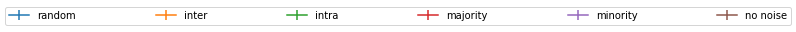

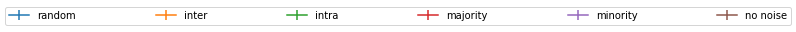

In [17]:
fig, legend_ax = plt.subplots(1, 1,figsize=(11, 0.5), sharey=True)
#fig.set_facecolor("black")
#fig.pad_inches(0)
fig.set_tight_layout(True)
#legend_ax.set_facecolor("black")
#legend_ax.set_ymargin(-0.1)
handles, labels = axs[0].get_legend_handles_labels()
legend_ax.axis('off')
print(legend_ax.margins())
#legend_ax.margins(y=0)
fontsize=10
fig.legend(handles, labels, loc='center', mode="expand", ncol=6,  fontsize=fontsize)
#legend_ax.set_autoscale(enable=True, tight=True)
display(fig)
fig.savefig(f'legend{fontsize}.'+filetype)


/home/felix/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


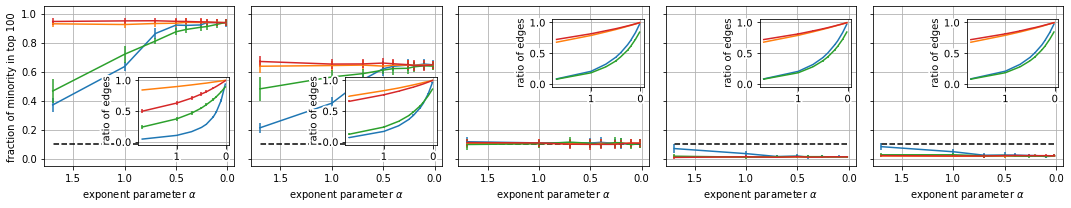

In [18]:

from matplotlib.transforms import IdentityTransform, TransformedBbox
def by_name(result_all, name):
    return result_all[result_all.sampler_name == name]
hs = [0.1,0.25, 0.5,0.75,0.9]
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
fig, axs = plt.subplots(1, len(hs),figsize=(15, 3), sharey=True)
fig.set_tight_layout(True)
for ax, h in zip(axs, hs):
    
    #ax1 = plt.subplots(1,len(hs),i+1, sharey=True)
    plot_across_noise_strength({
        #'uniform' : (by_name(result_all,'uniform'), 'desired_fraction'),
#        'structure' : (result2,'alpha'),
        'jaccard' : (by_name(result_all,'jaccard'),'alpha'),
        'inv jaccard' : (by_name(result_all,'inv jaccard'),'alpha'),
        'centrality' : (by_name(result_all, 'structure'),'alpha'),
        'inv centrality' : (by_name(result_all, 'inv structure'),'alpha'),
        #'majority' : (by_name(result_all,'majority'),'rate'),
        #'minority' : (by_name(result_all,'minority'),'rate'),
        #'no sampling' : (by_name(result_all,'minority'),'no sampling'),
#        'jaccard' : (result5, 'alpha')
    },
                               h=h,
                               k=100,
    ax=ax)
    ax.set_xlabel(r"exponent parameter $\alpha$")
    ax.set_xlim((ax.get_xlim()[1], ax.get_xlim()[0]))
    #ax.set_xlim([0.01,0.99])
    ax.grid(True)
axs[0].set_ylabel(f"fraction of minority in top {100}")
#axs[0].legend(fontsize=16)
#plt.show()
import matplotlib.patches as patches
axs2 = []
locs = [4,4,1,1,1]
for ax,loc in zip(axs, locs):
    #ax.add_patch(patches.Rectangle((0.2,0.1),0.6,0.5, fc="red"))
    ax2 =  inset_axes(ax, width="60%", height="50%", loc=loc, bbox_to_anchor=(.2, .1, .8, 0.85),
                   bbox_transform=ax.transAxes,)
    axs2.append(ax2)


for ax, h in zip(axs2, hs):
    plot_num_edges_outer({
        #'uniform' : (by_name(result_all,'inter'), 'desired_fraction'),
#        'structure' : (result2,'alpha'),
        'jaccard' : (by_name(result_all,'jaccard'),'alpha'),
        'inv jaccard' : (by_name(result_all,'inv jaccard'),'alpha'),
         'structure' : (by_name(result_all, 'structure'),'alpha'),
        'inv structure' : (by_name(result_all, 'inv structure'),'alpha'),
#        'majority' : (by_name(result_all,'majority'),'rate'),
#        'minority' : (by_name(result_all,'minority'),'rate'),
#        'jaccard' : (result5, 'alpha')
    },
   h=h,
    ax=ax)
    ax.set_xlim((ax.get_xlim()[1], ax.get_xlim()[0]))
    #ax.set_xlabel(r"retain parameter $\rho$")
    ax.set_ylabel(r"ratio of edges")
    ax.grid(True)
    
for ax2 in axs2:
    linewidth=4
    from matplotlib.patheffects import withStroke
    plt.setp(ax2.yaxis.get_majorticklabels(),
             path_effects=[withStroke(foreground="w", linewidth=4)])
    plt.setp(ax2.xaxis.get_majorticklabels(),
             path_effects=[withStroke(foreground="w", linewidth=4)])
    plt.setp(ax2.yaxis.get_label(),
             path_effects=[withStroke(foreground="w", linewidth=4)])

#axs[0].set_ylabel(f"number of edges")
#axs[0].legend(fontsize=16)
plt.show()


if True: # enable saving here
    for i,(ax, h) in enumerate(zip(axs, hs)):
        box = ax.get_tightbbox(fig.canvas.get_renderer()).expanded(1.02,1).transformed(fig.dpi_scale_trans.inverted())
        #box = full_extent(ax,0.01).transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(f'by_retain_alpha{i}.'+filetype, bbox_inches=box)

(0.05, 0.05)


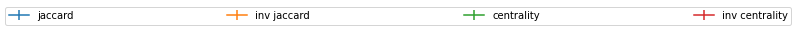

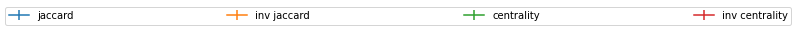

In [19]:
fig, legend_ax = plt.subplots(1, 1,figsize=(11, 0.5), sharey=True)
#fig.set_facecolor("black")
#fig.pad_inches(0)
fig.set_tight_layout(True)
#legend_ax.set_facecolor("black")
#legend_ax.set_ymargin(-0.1)
handles, labels = axs[0].get_legend_handles_labels()
legend_ax.axis('off')
print(legend_ax.margins())
#legend_ax.margins(y=0)
fontsize=10
fig.legend(handles, labels, loc='center', mode="expand", ncol=6,  fontsize=fontsize)
#legend_ax.set_autoscale(enable=True, tight=True)
display(fig)
fig.savefig(f'legend_struct{fontsize}.'+filetype)

In [20]:
result_all['sampler_name'].unique()

array(['inter', 'intra', 'majority', 'minority', 'uniform', 'no sampling',
       'jaccard', 'inv jaccard', 'structure', 'inv structure'],
      dtype=object)

In [21]:
def my_cmap2(cmap, x,):
    return plt.get_cmap("Reds")(x/2)
def plot_distr_outer(result,
                     show_std=False,
                     invert=False,
                     index=[0,0],
                     outer='retain_factor',
                     normalize=False,
                     show_legend=False,
                     use_threshold=True):
    if outer=="alpha":
        x = result[outer]
        #print(np.unique(x))
        #x=x+5
        #x=x-x.min()
        #x+=1
        #x=x/(x.max())
        result['rate'] = x#(x + 0.2)/1.2
        #print(result['alpha'])
    else:
        result['rate'] = result[outer]
        #result['rate'] = (x + 0.2)/1.2
    #print(np.unique(result['rate']))
    figs=[]
    arr = np.unique(result.rate)
    #arr=arr[3:]
    if outer == 'alpha':
        arr=arr[::-1]
    for sample_rate, cval in zip(arr, np.linspace(0.1,1,len(arr))):#([arr[0], arr[1],arr[-2],arr[-1]], [0.3,0.55,0.75,0.999]):#np.unique(result.rate):
        result_tmp=result[result.rate==sample_rate]
        colors=(plt.get_cmap('Blues')(cval), plt.get_cmap('Reds')(cval))
        figs=plot_distr(result_tmp,
                        figures=figs,
                        prefix="retain="+str(sample_rate)+" ",
                        colors=colors,
                        groupby=['homophily'],
                        normalize=normalize,
                        show_std=show_std,
                        plus_one=True,
                       use_threshold=use_threshold)
    for fig in figs:
        ax = fig.axes[0]
        if not show_legend:
            ax.legend().set_visible(False)
        display(fig)
        plt.close(fig)

In [22]:
result_all[result_all['sampler_name']=='intra'].copy()

,n,m,minority_fraction,homophily,retain_matrix,sampler_name,desired_fraction,sim_type,alpha,centrality,...,degree_distr_cumsum_maj,degree_distr_cumsum_maj_x,degree_distr_cumsum_min,degree_distr_cumsum_min_x,degree_min_places,degree_maj_places,minority_measured,edge_raw,run,rate
5,10000,1,0.1,0.1,"[[0.1, 0.9], [0.9, 0.1]]",intra,NaN,NaN,NaN,NaN,...,"[1.0, 0.9998888888888889, 0.9997777777777778, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.999, 0.998, 0.997, 0.996, 0.995, 0.994...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.1,"[11, 7056, 830, 120]",9,0.1
6,10000,1,0.1,0.1,"[[0.3, 0.9], [0.9, 0.3]]",intra,NaN,NaN,NaN,NaN,...,"[1.0, 0.9998888888888889, 0.9997777777777778, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.999, 0.998, 0.997, 0.996, 0.995, 0.994...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.1,"[28, 7108, 840, 354]",9,0.3
7,10000,1,0.1,0.1,"[[0.5, 0.9], [0.9, 0.5]]",intra,NaN,NaN,NaN,NaN,...,"[1.0, 0.9998888888888889, 0.9997777777777778, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.999, 0.998, 0.997, 0.996, 0.995, 0.994...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.1,"[33, 6979, 844, 578]",9,0.5
8,10000,1,0.1,0.1,"[[0.7, 0.9], [0.9, 0.7]]",intra,NaN,NaN,NaN,NaN,...,"[1.0, 0.9998888888888889, 0.9997777777777778, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.999, 0.998, 0.997, 0.996, 0.995, 0.994...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.1,"[54, 7068, 849, 833]",9,0.7
9,10000,1,0.1,0.1,"[[0.9, 0.9], [0.9, 0.9]]",intra,NaN,NaN,NaN,NaN,...,"[1.0, 0.9998888888888889, 0.9997777777777778, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.999, 0.998, 0.997, 0.996, 0.995, 0.994...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.1,"[72, 7071, 832, 1036]",9,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3043,10000,1,0.1,0.9,"[[0.1, 0.9], [0.9, 0.1]]",intra,NaN,NaN,NaN,NaN,...,"[1.0, 0.9998888888888889, 0.9997777777777778, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.999, 0.998, 0.997, 0.996, 0.995, 0.994...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.1,"[58, 75, 512, 902]",0,0.1
3044,10000,1,0.1,0.9,"[[0.3, 0.9], [0.9, 0.3]]",intra,NaN,NaN,NaN,NaN,...,"[1.0, 0.9998888888888889, 0.9997777777777778, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.999, 0.998, 0.997, 0.996, 0.995, 0.994...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.1,"[129, 78, 516, 2579]",0,0.3
3045,10000,1,0.1,0.9,"[[0.5, 0.9], [0.9, 0.5]]",intra,NaN,NaN,NaN,NaN,...,"[1.0, 0.9998888888888889, 0.9997777777777778, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.999, 0.998, 0.997, 0.996, 0.995, 0.994...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.1,"[209, 70, 522, 4395]",0,0.5
3046,10000,1,0.1,0.9,"[[0.7, 0.9], [0.9, 0.7]]",intra,NaN,NaN,NaN,NaN,...,"[1.0, 0.9998888888888889, 0.9997777777777778, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.999, 0.998, 0.997, 0.996, 0.995, 0.994...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0

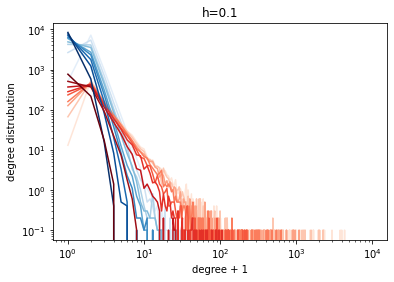

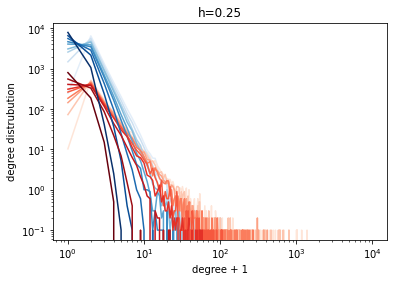

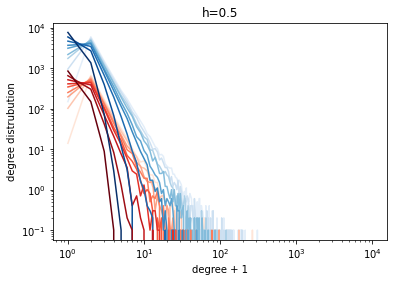

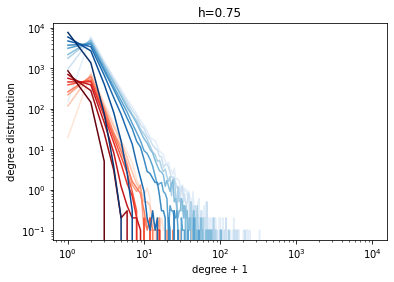

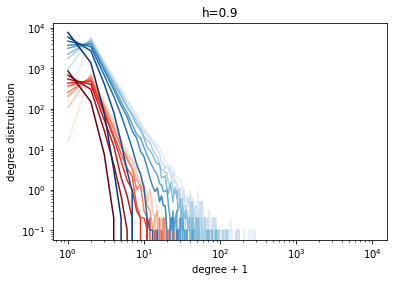

In [23]:
df = result_all[result_all['sampler_name']=='jaccard'].copy()

df['retain_factor'] = df.alpha#df.retain_matrix.apply(lambda x: x[0,0])
plot_distr_outer(df, normalize=False, show_std=False, use_threshold=False )

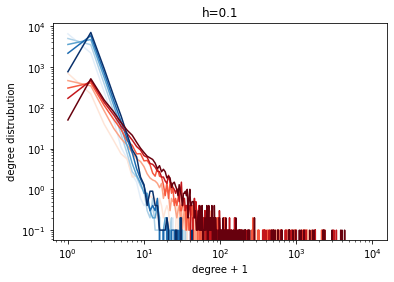

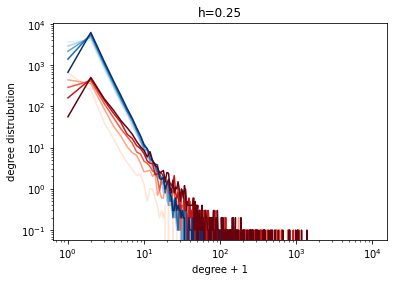

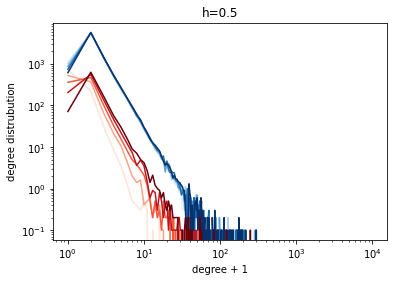

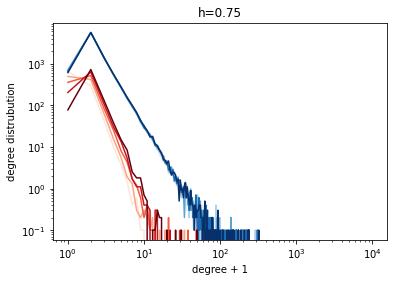

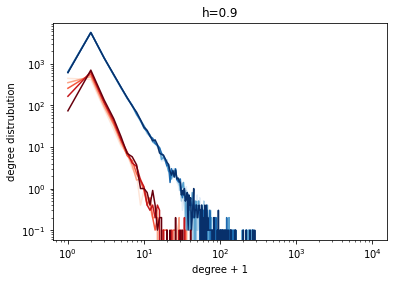

In [24]:
df = result_all[result_all['sampler_name']=='inter'].copy()
df['retain_factor'] = df.retain_matrix.apply(lambda x: x[1,0])
df
plot_distr_outer(df, normalize=False, show_std=False, show_legend=False, use_threshold=False)